In [1]:
!pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [2]:

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')



In [4]:
# Cell 2: Load dataset and inspect it
df = pd.read_csv("../data/smarteta_dataset.csv")
df.head()


,order_id,order_time,distance_km,order_items,weather,traffic,rider_queue,prep_time_min,delivery_time_min
0,1,2025-01-09 08:39:00,4.06,3,Clear,5,0,8,22.3
1,2,2025-01-26 04:43:00,9.53,8,Clear,1,0,24,53.4
2,3,2025-03-19 02:29:00,7.45,7,Clear,2,4,13,45.8
3,4,2025-01-24 21:20:00,6.19,3,Rain,2,3,10,43.7
4,5,2025-03-10 11:27:00,1.98,6,Clear,0,1,7,12.0


In [5]:
# Cell 3: Feature engineering - extract hour and drop order_id
df["order_hour"] = pd.to_datetime(df["order_time"]).dt.hour
df = df.drop(columns=["order_id", "order_time"])  # Drop non-useful columns

df.head()


,distance_km,order_items,weather,traffic,rider_queue,prep_time_min,delivery_time_min,order_hour
0,4.06,3,Clear,5,0,8,22.3,8
1,9.53,8,Clear,1,0,24,53.4,4
2,7.45,7,Clear,2,4,13,45.8,2
3,6.19,3,Rain,2,3,10,43.7,21
4,1.98,6,Clear,0,1,7,12.0,11


In [ ]:
# Cell 4: Train-test split and model training pipeline
import joblib
# Features and target
X = df.drop("delivery_time_min", axis=1)
y = df["delivery_time_min"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define categorical and numeric columns
categorical_cols = ["weather"]
numeric_cols = [col for col in X.columns if col not in categorical_cols]

# Preprocessing and modeling pipeline
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42))
])

# Train the model
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5

r2 = r2_score(y_test, y_pred)

mae, rmse, r2
joblib.dump(pipeline, "model/xgb_eta_model1.pkl")
print("✅ Model saved to model/xgb_eta_model1.pkl")

ImportError: cannot import name 'pipeline' from 'sklearn.pipeline' (c:\Users\mohan\Desktop\code\AI\MajorDev\SmartETA_Pro\.venv\Lib\site-packages\sklearn\pipeline.py)

In [17]:
# model/train_model.py

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import joblib

# Load dataset
df = pd.read_csv("../data/smarteta_dataset.csv")

# Feature engineering
df["order_hour"] = pd.to_datetime(df["order_time"]).dt.hour
df.drop(columns=["order_id", "order_time"], inplace=True)

# Features and target
X = df.drop("delivery_time_min", axis=1)
y = df["delivery_time_min"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define column types
categorical_cols = ["weather"]
numeric_cols = [col for col in X.columns if col not in categorical_cols]

# Preprocessing + model pipeline
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
], remainder="passthrough")

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42))
])

# Train model
pipeline.fit(X_train, y_train)

# Evaluate
y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Save model
joblib.dump(pipeline, "xgb_eta_model.pkl")
print("✅ Model saved to model/xgb_eta_model.pkl")


MAE: 2.54
RMSE: 3.19
R² Score: 0.93
✅ Model saved to model/xgb_eta_model.pkl


In [ ]:
predict_eta({
    "distance_km": 5.2,
    "order_items": 3,
    "weather": "Rain",
    "traffic": 3,
    "rider_queue": 2,
    "prep_time_min": 15,
    "order_hour": 18
})


NameError: name 'predict_eta' is not defined

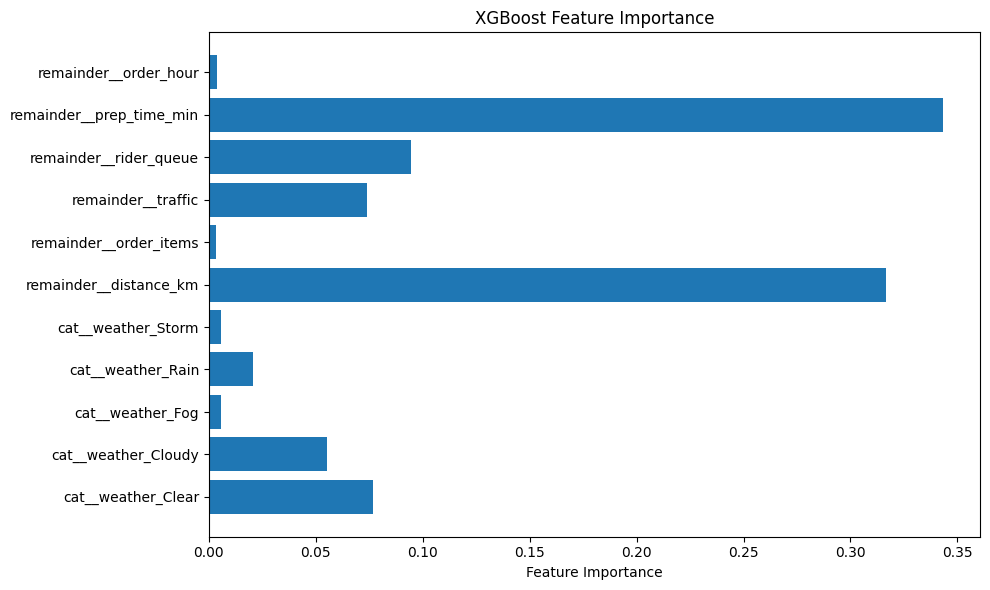

In [7]:
import matplotlib.pyplot as plt

# Get feature names from the preprocessor
feature_names = model.named_steps["preprocessor"].get_feature_names_out()
xgb_model = model.named_steps["regressor"]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, xgb_model.feature_importances_)
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()
